In [1]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import warnings
warnings.filterwarnings('ignore')
from empyrical import max_drawdown,cum_returns_final,cum_returns,sortino_ratio,sharpe_ratio,calmar_ratio,annual_return,annual_volatility

import matplotlib.pyplot as plt

import time
import datetime as dt
from datetime import timedelta
from pytz import timezone

import yfinance as yf
from datetime import date
import itertools as it

In [2]:
from platform import python_version

print(python_version())

3.7.4


# LOAD DATA V1

In [3]:
import_path = '/Users/niclaswolnerhanssen/Desktop/LINC/Sentiment LYNX/2_SIGNAL_PROCESSING/'

V1_TWITTER_ZSCORED                      = pd.read_excel(
    import_path+'V1_TWITTER_ZSCORED.xlsx',index_col=0)
V1_REDDIT_ZSCORED                       = pd.read_excel(
    import_path+'V1_REDDIT_ZSCORED.xlsx',index_col=0)
V1_BLOOMBERG_ZSCORED                    = pd.read_excel(
    import_path+'V1_BLOOMBERG_ZSCORED.xlsx',index_col=0)
V1_TWITTER_REDDIT_ZSCORED               = pd.read_excel(
    import_path+'V1_TWITTER_REDDIT_ZSCORED.xlsx',index_col=0)
V1_TWITTER_REDDIT_BLOOMBERG_ZSCORED     = pd.read_excel(
    import_path+'V1_TWITTER_REDDIT_BLOOMBERG_ZSCORED.xlsx',index_col=0)
V1_EMA_ZSCORED                          = pd.read_excel(
    import_path+'V1_EMA_ZSCORED.xlsx',index_col=0)
V1_EMA_TWITTER_ZSCORED                  = pd.read_excel(
    import_path+'V1_EMA_TWITTER_ZSCORED.xlsx',index_col=0)
V1_EMA_REDDIT_ZSCORED                   = pd.read_excel(
    import_path+'V1_EMA_REDDIT_ZSCORED.xlsx',index_col=0)
V1_EMA_BLOOMBERG_ZSCORED                = pd.read_excel(
    import_path+'V1_EMA_BLOOMBERG_ZSCORED.xlsx',index_col=0)
V1_EMA_TWITTER_REDDIT_ZSCORED           = pd.read_excel(
    import_path+'V1_EMA_TWITTER_REDDIT_ZSCORED.xlsx',index_col=0)
V1_EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED = pd.read_excel(
    import_path+'V1_EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED.xlsx',index_col=0)
OPEN_TO_CLOSE_STOCK_RETURNS             = pd.read_excel(
    import_path+'V1_OPEN_TO_CLOSE_STOCK_RETURNS.xlsx',index_col=0)
OPEN_TO_CLOSE_EQUALW_RETURNS            = pd.read_excel(
    import_path+'V1_OPEN_TO_CLOSE_EQUALW_RETURNS.xlsx',index_col=0)
OPEN_TO_CLOSE_XLK_RETURNS               = pd.read_excel(
    import_path+'V1_OPEN_TO_CLOSE_XLK_RETURNS.xlsx',index_col=0)
OPEN_TO_OPEN_STOCK_RETURNS              = pd.read_excel(
    import_path+'V1_OPEN_TO_OPEN_STOCK_RETURNS.xlsx',index_col=0)
OPEN_TO_OPEN_EQUALW_RETURNS             = pd.read_excel(
    import_path+'V1_OPEN_TO_OPEN_EQUALW_RETURNS.xlsx',index_col=0)
OPEN_TO_OPEN_XLK_RETURNS                = pd.read_excel(
    import_path+'V1_OPEN_TO_OPEN_XLK_RETURNS.xlsx',index_col=0)

# BACKTEST

$ R_{p} = \sum \limits _{i=1} ^{N} w_{i}r_{i} $

Portfolio return, $R_{p}$, is the sum of the stock-specific return, $r_{i}$, multiplied by the stocks portfolio weight, $w_{i}$. 

### 1. calculate quantile

First we decide where to draw the line for which stocks to long/short

In [4]:
#df = V1_TWITTER_ZSCORED.copy()
signal_df = V1_TWITTER_ZSCORED.copy()
returns_df = OPEN_TO_CLOSE_STOCK_RETURNS.copy()
upper_q = 0.5
lower_q = 0.5
min_stocks_each_basket = 1
extra_weight = 0.2 # in min-max weighting due to min value is removed from the lowest value, 
                   #making the smallest value having zero weight which is a problem
                   # when the number of stocks in each basket is small.

In [5]:
signal_df['RETURNS'] = returns_df['STOCK_RETURNS']

So the idea is to iterate through the dates and calculate the quantile thresholds on each date, calculating the weights then multiply the weights by 0.5 times return for specific stock, then we sum toghether all collected returns to get the porfolio return for that day. 

In [6]:
#create date list
date_list = signal_df['Date'].unique()
feat_name = signal_df.columns[2]

Here is the iteration:

In [7]:
#for i in date_list:
#date_df = df[df['Date']==i]
date_df = signal_df[signal_df['Date']==date_list[0]]

    

And this is what each days data frame looks like:

In [8]:
date_df

,Date,Stock,TWITTER,RETURNS
0,2020-12-24,AAPL,-0.318619,0.004950
1,2020-12-24,ACN,NaN,-0.002713
2,2020-12-24,ADBE,NaN,0.001402
3,2020-12-24,ADI,NaN,0.002498
4,2020-12-24,ADP,NaN,0.002498
...,...,...,...,...
70,2020-12-24,VRSN,NaN,-0.002974
71,2020-12-24,WDC,NaN,-0.007752
72,2020-12-24,WU,NaN,0.003673
73,2020-12-24,XLNX,NaN,-0.008034


Now we want to divide this date_df by the quantile thresholds of the zscores to a long and short daily df:

In [9]:
#create seperat long/short dfs by quantile
long_date_df  = date_df[date_df[feat_name]>date_df.quantile(q=upper_q)[0]]
short_date_df = date_df[date_df[feat_name]<date_df.quantile(q=lower_q)[0]]

Then some conditions: if there is lower than min_stocks in either basket we do not want to trade, also if there is only 1 stock in either portfolio we want to assign a 0.5 weights to that stock return (50/50 allocation between long/short baskets)

In [10]:
#There must be more stocks than min_stocks in each basket to trade 
if (len(long_date_df)<min_stocks_each_basket)|(len(short_date_df)<min_stocks_each_basket):
    NO_VALUES = True

else:
    NO_VALUES = False
    
if NO_VALUES:
    #append stuff with zeroes:
    #date_list.append(i)
    #total_returns_date_df_list.append(0) 
    print('empty')
    
else:
    if len(long_date_df)==1:
        ONLY_1_LONG = True
    if len(short_date_df)==1:
        ONLY_1_SHORT = True 
      

In this example there was only 1 stock in each basket

In [11]:
long_date_df

,Date,Stock,TWITTER,RETURNS
0,2020-12-24,AAPL,-0.318619,0.00495


In [12]:
short_date_df

,Date,Stock,TWITTER,RETURNS
17,2020-12-24,CRM,-0.464505,-0.011038


### weights

Here we do the min-max weighting. Notice the -1 multiplication in the short basket, this is to flip the magnitude so that low zscores have the highest short weight and vice versa. Another thing is the "extra_weight" which I have choosen to be 0.2, so this is done on the min-max transformed values so that the smallest zscore-value does not get weight 0, the 0.2 is rather arbitrary choosen on the few example I have seen with the naked eye it reflects the zscores somewhat okey, this is mostly a issue when there are small number of stocks.

In [13]:
#SHORT
short_date_df['MIN-MAX'] = ((short_date_df[feat_name]*-1) - (short_date_df[feat_name]*-1).min())/(
                            (short_date_df[feat_name]*-1).max() - (short_date_df[feat_name]*-1).min())

short_date_df['MIN-MAX'] = short_date_df['MIN-MAX']+extra_weight
short_date_df['MIN-MAX-WEIGHT'] = short_date_df['MIN-MAX']/short_date_df['MIN-MAX'].sum()
short_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(short_date_df))*-1

#LONG
long_date_df['MIN-MAX'] = ((long_date_df[feat_name]) - (long_date_df[feat_name]).min())/(
                            (long_date_df[feat_name]).max() - (long_date_df[feat_name]).min())
long_date_df['MIN-MAX'] = long_date_df['MIN-MAX']+extra_weight
long_date_df['MIN-MAX-WEIGHT'] = long_date_df['MIN-MAX']/long_date_df['MIN-MAX'].sum()
long_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(long_date_df)) 

In [14]:
long_date_df.head()

,Date,Stock,TWITTER,RETURNS,MIN-MAX,MIN-MAX-WEIGHT,LONG/SHORT MULTIPLIER
0,2020-12-24,AAPL,-0.318619,0.00495,NaN,NaN,1.0


In [15]:
short_date_df.head()

,Date,Stock,TWITTER,RETURNS,MIN-MAX,MIN-MAX-WEIGHT,LONG/SHORT MULTIPLIER
17,2020-12-24,CRM,-0.464505,-0.011038,NaN,NaN,-1.0


Here is that condition about only being 1 stock in the basket:

In [16]:
###If there is only one stock in either basket, the stock should have 0.5*return, 
if ONLY_1_LONG==True:
    long_date_df['WEIGHTED RETURNS'] = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER']
else:
    long_date_df['WEIGHTED RETURNS']  = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER'] *long_date_df['MIN-MAX-WEIGHT']
    
if ONLY_1_SHORT==True:
    short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']
else:
    short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']*short_date_df['MIN-MAX-WEIGHT']




In [17]:
long_date_df

,Date,Stock,TWITTER,RETURNS,MIN-MAX,MIN-MAX-WEIGHT,LONG/SHORT MULTIPLIER,WEIGHTED RETURNS
0,2020-12-24,AAPL,-0.318619,0.00495,NaN,NaN,1.0,0.002475


In [18]:
short_date_df

,Date,Stock,TWITTER,RETURNS,MIN-MAX,MIN-MAX-WEIGHT,LONG/SHORT MULTIPLIER,WEIGHTED RETURNS
17,2020-12-24,CRM,-0.464505,-0.011038,NaN,NaN,-1.0,0.005519


Time for wrapping things up!

In [19]:
#only on trading days (if min_stock is fulfilled)
long_returns_date_sum = long_date_df['WEIGHTED RETURNS'].sum()#append
short_returns_date_sum = short_date_df['WEIGHTED RETURNS'].sum()#append
total_returns_date_sum = long_returns_date_sum+short_returns_date_sum#append
diagnostics_df = pd.concat([long_date_df,short_date_df]).sort_index()#append

In [20]:
diagnostics_df

,Date,Stock,TWITTER,RETURNS,MIN-MAX,MIN-MAX-WEIGHT,LONG/SHORT MULTIPLIER,WEIGHTED RETURNS
0,2020-12-24,AAPL,-0.318619,0.004950,NaN,NaN,1.0,0.002475
17,2020-12-24,CRM,-0.464505,-0.011038,NaN,NaN,-1.0,0.005519


# Throwing all into a function

In [21]:
def backtest_minmax(signal_df,returns_df,upper_q=0.5,lower_q = 0.5,min_stocks_each_basket = 1,extra_weight = 0.2):
    signal_df['RETURNS'] = returns_df['STOCK_RETURNS']
    #create date list
    date_list = signal_df['Date'].unique()
    feat_name = signal_df.columns[2]
    
    DATES = []
    TRADE_DATES = []
    MKT_NEUTRAL_RETURNS = []
    LONG_RETURNS = []
    SHORT_RETURNS = []
    DIAGNOSTICS = []
    
    
    for i in date_list:
        date_df = signal_df[signal_df['Date']==i]

        #create seperat long/short dfs by quantile
        long_date_df  = date_df[date_df[feat_name]>date_df.quantile(q=upper_q)[0]]
        short_date_df = date_df[date_df[feat_name]<date_df.quantile(q=lower_q)[0]]
        
        #There must be more stocks than min_stocks in each basket to trade 
        if (len(long_date_df)<min_stocks_each_basket)|(len(short_date_df)<min_stocks_each_basket):
            NO_VALUES = True

        else:
            NO_VALUES = False

        if NO_VALUES==True:
            DATES.append(i)
            MKT_NEUTRAL_RETURNS.append(0) 
            continue
        
        if len(long_date_df)==1:
            ONLY_1_LONG = True
        else:
            ONLY_1_LONG = False
            
        if len(short_date_df)==1:
            ONLY_1_SHORT = True
        else:
            ONLY_1_SHORT = False
            
        ########WEIGHTS
        
        #SHORT
        short_date_df['MIN-MAX'] = ((short_date_df[feat_name]*-1) - (short_date_df[feat_name]*-1).min())/(
                                    (short_date_df[feat_name]*-1).max() - (short_date_df[feat_name]*-1).min())

        short_date_df['MIN-MAX'] = short_date_df['MIN-MAX']+extra_weight
        short_date_df['MIN-MAX-WEIGHT'] = short_date_df['MIN-MAX']/short_date_df['MIN-MAX'].sum()
        short_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(short_date_df))*-1

        #LONG
        long_date_df['MIN-MAX'] = ((long_date_df[feat_name]) - (long_date_df[feat_name]).min())/(
                                    (long_date_df[feat_name]).max() - (long_date_df[feat_name]).min())
        long_date_df['MIN-MAX'] = long_date_df['MIN-MAX']+extra_weight
        long_date_df['MIN-MAX-WEIGHT'] = long_date_df['MIN-MAX']/long_date_df['MIN-MAX'].sum()
        long_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(long_date_df)) 
        
        ########RETURNS
        
        if ONLY_1_LONG==True:
            long_date_df['WEIGHTED RETURNS']  = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER']
        else:
            long_date_df['WEIGHTED RETURNS']  = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER'] *long_date_df['MIN-MAX-WEIGHT']

        if ONLY_1_SHORT==True:
            short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']
        else:
            short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']*short_date_df['MIN-MAX-WEIGHT']

                
        ######APPEND
        
        #only on trading days (if min_stock is fulfilled)
        long_returns_date_sum = long_date_df['WEIGHTED RETURNS'].sum()#append
        LONG_RETURNS.append(long_returns_date_sum)
        
        short_returns_date_sum = short_date_df['WEIGHTED RETURNS'].sum()#append
        SHORT_RETURNS.append(short_returns_date_sum)
        
        total_returns_date_sum = long_returns_date_sum+short_returns_date_sum#append
        MKT_NEUTRAL_RETURNS.append(total_returns_date_sum)
        
        diagnostics_df = pd.concat([long_date_df,short_date_df]).sort_index()#append
        DIAGNOSTICS.append(diagnostics_df)
        
        TRADE_DATES.append(i)
        DATES.append(i)
        
    ##########pile to dfs
    
    STRATEGY_RETURNS            = pd.DataFrame(index=DATES)
    STRATEGY_RETURNS[feat_name] = MKT_NEUTRAL_RETURNS
    
    LS_RETURNS = pd.DataFrame(index=TRADE_DATES)
    LS_RETURNS[feat_name+'_LONG_RETURNS']  = LONG_RETURNS
    LS_RETURNS[feat_name+'_SHORT_RETURNS'] = SHORT_RETURNS
    
    #LS_returns only includes when returns when trading, so cumulative rets are going to be wrong, lets fix:
    LS_RETURNS = pd.concat([STRATEGY_RETURNS,LS_RETURNS],axis=1)
    LS_RETURNS = LS_RETURNS.drop(feat_name,axis=1)
    LS_RETURNS = LS_RETURNS.replace(np.nan,0)
    
    DIAGNOSTICS_DF = pd.concat(DIAGNOSTICS)
    
    return STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF
    
    

In [22]:
def backtest_metrics(df):
    
    annualization=250       
    
    df_list = []
    for i in df.columns:
        df_series_ret = df[i]
        
        df_met = pd.DataFrame(index=['CAGR','Ann. Vol','Cumulative Ret.','MDD','Sharpe Ratio','Sortino Ratio','Calmar Ratio'])
        annual_ret = str( round(annual_return(df_series_ret,annualization=annualization)*100,2))+'%'
        annual_vol = str( round(annual_volatility(df_series_ret,annualization=annualization)*100,2))+'%'
        cum_ret = str( round(cum_returns_final(df_series_ret)*100,2))+'%'
        mdd= str( round(max_drawdown(df_series_ret)*100,2))+'%'
        sharpe = str( round(sharpe_ratio(df_series_ret,annualization=annualization),2))
        sort = str( round(sortino_ratio(df_series_ret,annualization=annualization),2))
        calmar = str( round(calmar_ratio(df_series_ret,annualization=annualization),2))

        df_met[df_series_ret.name] = [annual_ret,annual_vol,cum_ret,mdd,sharpe,sort,calmar]
        df_met = df_met.T
        df_list.append(df_met)
    
    df_2 = pd.concat(df_list)
    
    return df_2


In [23]:
STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF = backtest_minmax(
                                                                 signal_df              = V1_TWITTER_ZSCORED,
                                                                 returns_df             = OPEN_TO_CLOSE_STOCK_RETURNS,
                                                                 upper_q                = 0.5,
                                                                 lower_q                = 0.5,
                                                                 min_stocks_each_basket = 1,
                                                                 extra_weight           = 0.2
                                                    )

In [24]:
DIAGNOSTICS_DF[DIAGNOSTICS_DF['Date']=='2021-11-02']

,Date,Stock,TWITTER,RETURNS,MIN-MAX,MIN-MAX-WEIGHT,LONG/SHORT MULTIPLIER,WEIGHTED RETURNS
16125,2021-11-02,AAPL,-2.653601e-01,0.009148,0.249892,0.047240,-1.0,-0.000216
16127,2021-11-02,ADBE,-1.849070e-10,-0.001123,0.203288,0.057127,1.0,-0.000032
16128,2021-11-02,ADI,6.508390e-01,0.016858,0.355976,0.100035,1.0,0.000843
16133,2021-11-02,AMD,-1.488847e+00,0.021203,1.200000,0.226848,-1.0,-0.002405
16134,2021-11-02,ANET,4.248529e+00,0.004677,1.200000,0.337218,1.0,0.000789
16143,2021-11-02,CSCO,5.173483e-16,0.022175,0.203288,0.057127,1.0,0.000633
16147,2021-11-02,ENPH,-9.746794e-01,-0.001848,0.800719,0.151368,-1.0,0.000140
16157,2021-11-02,IBM,-2.011126e-01,-0.000950,0.200000,0.037808,-1.0,0.000018
16158,2021-11-02,INTC,-7.152199e-01,0.005039,0.599234,0.113279,-1.0,-0.000285
16166,2021-11-02,LRCX,-1.077549e+00,-0.000870,0.880603,0.166470,-1.0,0.000072


In [25]:
APPLE_RETURN = 0.009148*0.047240*-1.0*0.5
APPLE_RETURN

-0.00021607575999999998

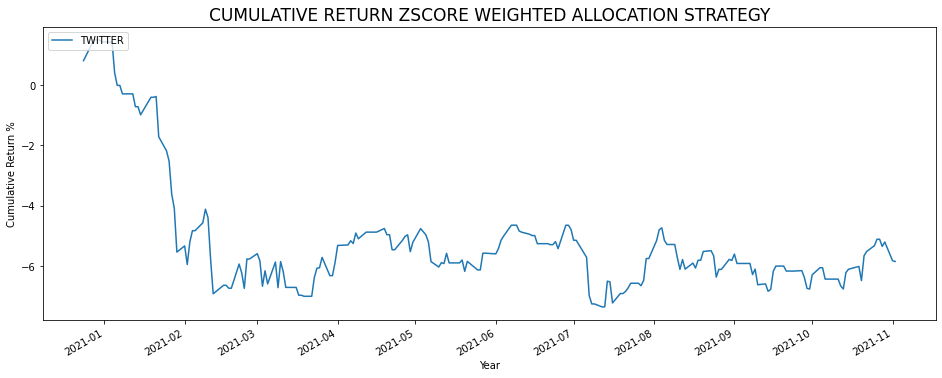

In [26]:
fig, ax = plt.subplots(figsize=(16,6))

cum = cum_returns(STRATEGY_RETURNS)*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN ZSCORE WEIGHTED ALLOCATION STRATEGY', size=17);

In [27]:
backtest_metrics(STRATEGY_RETURNS)

,CAGR,Ann. Vol,Cumulative Ret.,MDD,Sharpe Ratio,Sortino Ratio,Calmar Ratio
TWITTER,-6.73%,6.57%,-5.84%,-8.7%,-1.03,-1.32,-0.77


# L/S RETURNS

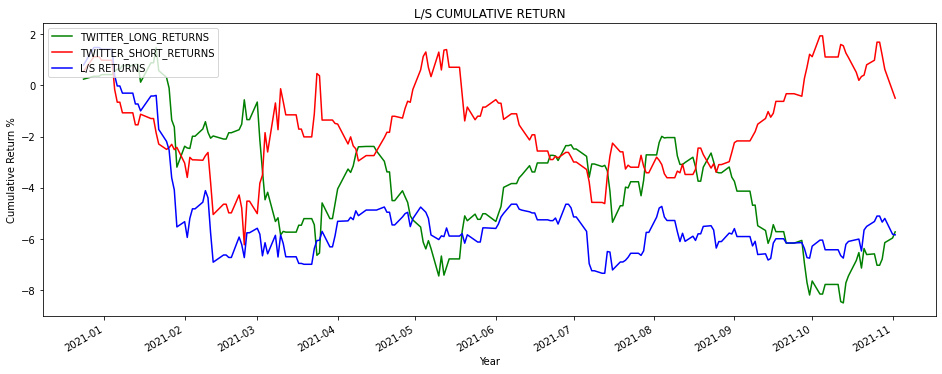

In [28]:
LS_RETURNS['L/S RETURNS'] = LS_RETURNS.sum(axis=1)

fig, ax = plt.subplots(figsize=(16,6))

cum = cum_returns(LS_RETURNS)*100

cum.plot(ax=ax,color = ['green','red','blue'])                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('L/S CUMULATIVE RETURN');

In [29]:
backtest_metrics(LS_RETURNS)

,CAGR,Ann. Vol,Cumulative Ret.,MDD,Sharpe Ratio,Sortino Ratio,Calmar Ratio
TWITTER_LONG_RETURNS,-6.6%,7.88%,-5.73%,-9.84%,-0.83,-1.08,-0.67
TWITTER_SHORT_RETURNS,-0.57%,8.27%,-0.5%,-7.27%,-0.03,-0.04,-0.08
L/S RETURNS,-6.73%,6.57%,-5.84%,-8.7%,-1.03,-1.32,-0.77


### TRADING DAYS

How many tradingdays? In "STRATEGY_RETURNS" whenever we are not trading, the returns are zero

In [30]:
def nr_of_trading_days(STRATEGY_RETURNS):
    NR_OF_ZERO_RETURNS_DAYS = len(STRATEGY_RETURNS[STRATEGY_RETURNS[STRATEGY_RETURNS.columns[0]]==0])
    NR_OF_DAYS = len(STRATEGY_RETURNS)

    return print('Nr of Trading Days, '+STRATEGY_RETURNS.columns[0]+': '+str(round(100*(1-(NR_OF_ZERO_RETURNS_DAYS/NR_OF_DAYS)),2))+'%')


In [31]:
nr_of_trading_days(STRATEGY_RETURNS)

Nr of Trading Days, TWITTER: 75.93%


### What stocks are we trading?

In the DIAGNOSTICS_DF we have some stats on the days when we are actually trading:

In [32]:
DIAGNOSTICS_DF.head()

,Date,Stock,TWITTER,RETURNS,MIN-MAX,MIN-MAX-WEIGHT,LONG/SHORT MULTIPLIER,WEIGHTED RETURNS
0,2020-12-24,AAPL,-0.318619,0.004950,NaN,NaN,1.0,0.002475
17,2020-12-24,CRM,-0.464505,-0.011038,NaN,NaN,-1.0,0.005519
92,2020-12-28,CRM,-0.283899,-0.011362,NaN,NaN,-1.0,0.005681
120,2020-12-28,MSFT,4.248529,0.002272,NaN,NaN,1.0,0.001136
300,2020-12-31,AAPL,0.219859,-0.010367,0.2,0.142857,1.0,-0.000740


In [33]:
def total_number_of_trading_stocks(DIAGNOSTICS_DF):
    total = len(DIAGNOSTICS_DF['Stock'].unique())
    return print('Total Nr of stocks trading: '+ str(total))

In [34]:
total_number_of_trading_stocks(DIAGNOSTICS_DF)

Total Nr of stocks trading: 24


### Mean holdings per trading day:

LONG/MULTIPLIER comes handy:

In [35]:
def stats_long_short(DIAGNOSTICS_DF):
    feat_name = DIAGNOSTICS_DF.columns[2]

    LONG_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==1]
    SHORT_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==-1]

    Long_holdings = []
    for i in LONG_PORTFOLIOS['Date'].unique():
        nr_of_long_holdings_per_trading_day = len(LONG_PORTFOLIOS[LONG_PORTFOLIOS['Date']==i])
        Long_holdings.append(nr_of_long_holdings_per_trading_day)

    Short_holdings = []
    for i in SHORT_PORTFOLIOS['Date'].unique():
        nr_of_short_holdings_per_trading_day = len(SHORT_PORTFOLIOS[SHORT_PORTFOLIOS['Date']==i])
        Short_holdings.append(nr_of_short_holdings_per_trading_day)

    Long_mean = np.mean(Long_holdings)
    Long_min  = np.min(Long_holdings)
    Long_max  = np.max(Long_holdings)

    Short_mean = np.mean(Short_holdings)
    Short_min  = np.min(Short_holdings)
    Short_max  = np.max(Short_holdings)

    df = pd.DataFrame(index=['MEAN','MIN','MAX'])
    df['LONG BASKET, '+feat_name] = [Long_mean,Long_min,Long_max]
    df['SHORT BASKET, '+feat_name] = [Short_mean,Short_min,Short_max]
    return df


In [36]:
stats_long_short(DIAGNOSTICS_DF)

,"LONG BASKET, TWITTER","SHORT BASKET, TWITTER"
MEAN,7.170732,7.189024
MIN,1.000000,1.000000
MAX,10.000000,10.000000


### long and short baskets

In [37]:
LONG_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==1]
SHORT_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==-1]

In [38]:
LONG_ALLOCATION_NAME = []
LONG_ALLOCATION_PERC = []
for i in LONG_PORTFOLIOS['Stock'].unique():
    trade_days = len(LONG_PORTFOLIOS[LONG_PORTFOLIOS['Stock']==i])
    long_days = len(LONG_PORTFOLIOS['Date'].unique())
    ratio = (trade_days/long_days)*100
    ratio = round(ratio,2)
    LONG_ALLOCATION_NAME.append(i)
    LONG_ALLOCATION_PERC.append(ratio)
    
df_long = pd.DataFrame(index=LONG_ALLOCATION_NAME)
df_long ['Long %'] = LONG_ALLOCATION_PERC
df_long            = df_long.sort_values('Long %',ascending=False)
df_long            = df_long.iloc[0:10,]

In [39]:
SHORT_ALLOCATION_NAME = []
SHORT_ALLOCATION_PERC = []
for i in SHORT_PORTFOLIOS['Stock'].unique():
    trade_days = len(SHORT_PORTFOLIOS[SHORT_PORTFOLIOS['Stock']==i])
    short_days = len(SHORT_PORTFOLIOS['Date'].unique())
    ratio = (trade_days/short_days)*100
    ratio = round(ratio,2)
    SHORT_ALLOCATION_NAME.append(i)
    SHORT_ALLOCATION_PERC.append(ratio)
    
df_short = pd.DataFrame(index=SHORT_ALLOCATION_NAME)
df_short ['Short %'] = SHORT_ALLOCATION_PERC
df_short            = df_short.sort_values('Short %',ascending=False)
df_short            = df_short.iloc[0:10,]

In [40]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [41]:
display_side_by_side(df_long,df_short)

,Long %
MSFT,54.88
QCOM,53.05
AAPL,51.22
ADP,50.00
LRCX,49.39
INTC,42.68
CSCO,42.68
TER,41.46
NVDA,40.85
ADI,35.98


In [42]:
def top_10_stocks_traded(DIAGNOSTICS_DF):
    feat_name = DIAGNOSTICS_DF.columns[2]
    LONG_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==1]
    SHORT_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==-1]
    
    #LONG BASKET
    LONG_ALLOCATION_NAME = []
    LONG_ALLOCATION_PERC = []
    for i in LONG_PORTFOLIOS['Stock'].unique():
        trade_days = len(LONG_PORTFOLIOS[LONG_PORTFOLIOS['Stock']==i])
        long_days = len(LONG_PORTFOLIOS['Date'].unique())
        ratio = (trade_days/long_days)*100
        ratio = round(ratio,2)
        LONG_ALLOCATION_NAME.append(i)
        LONG_ALLOCATION_PERC.append(ratio)

    df_long = pd.DataFrame(index=LONG_ALLOCATION_NAME)
    df_long [feat_name+' LONG %'] = LONG_ALLOCATION_PERC
    df_long            = df_long.sort_values(feat_name+' LONG %',ascending=False)
    df_long            = df_long.iloc[0:10,]
    
    #SHORT BASKET
    SHORT_ALLOCATION_NAME = []
    SHORT_ALLOCATION_PERC = []
    for i in SHORT_PORTFOLIOS['Stock'].unique():
        trade_days = len(SHORT_PORTFOLIOS[SHORT_PORTFOLIOS['Stock']==i])
        short_days = len(SHORT_PORTFOLIOS['Date'].unique())
        ratio = (trade_days/short_days)*100
        ratio = round(ratio,2)
        SHORT_ALLOCATION_NAME.append(i)
        SHORT_ALLOCATION_PERC.append(ratio)

    df_short = pd.DataFrame(index=SHORT_ALLOCATION_NAME)
    df_short [feat_name+' SHORT %'] = SHORT_ALLOCATION_PERC
    df_short            = df_short.sort_values(feat_name+' SHORT %',ascending=False)
    df_short            = df_short.iloc[0:10,]
    
    #DISPLAY STUFF
    
    from IPython.display import display_html
    from itertools import chain,cycle
    def display_side_by_side(*args,titles=cycle([''])):
        html_str=''
        for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
            html_str+='<th style="text-align:center"><td style="vertical-align:top">'
            html_str+=f'<h2>{title}</h2>'
            html_str+=df.to_html().replace('table','table style="display:inline"')
            html_str+='</td></th>'
        display_html(html_str,raw=True)
        
    return display_side_by_side(df_long,df_short)
    

In [43]:
top_10_stocks_traded(DIAGNOSTICS_DF)

,TWITTER LONG %
MSFT,54.88
QCOM,53.05
AAPL,51.22
ADP,50.00
LRCX,49.39
INTC,42.68
CSCO,42.68
TER,41.46
NVDA,40.85
ADI,35.98


In [44]:
DIAGNOSTICS_DF

,Date,Stock,TWITTER,RETURNS,MIN-MAX,MIN-MAX-WEIGHT,LONG/SHORT MULTIPLIER,WEIGHTED RETURNS
0,2020-12-24,AAPL,-3.186192e-01,0.004950,NaN,NaN,1.0,0.002475
17,2020-12-24,CRM,-4.645052e-01,-0.011038,NaN,NaN,-1.0,0.005519
92,2020-12-28,CRM,-2.838986e-01,-0.011362,NaN,NaN,-1.0,0.005681
120,2020-12-28,MSFT,4.248529e+00,0.002272,NaN,NaN,1.0,0.001136
300,2020-12-31,AAPL,2.198594e-01,-0.010367,0.200000,0.142857,1.0,-0.000740
...,...,...,...,...,...,...,...,...
16178,2021-11-02,ORCL,-4.094473e-01,0.022832,0.361784,0.068392,-1.0,-0.000781
16182,2021-11-02,PYPL,-6.346195e-01,-0.013245,0.536643,0.101447,-1.0,0.000672
16183,2021-11-02,QCOM,-8.800870e-22,0.005054,0.203288,0.057127,1.0,0.000144
16187,2021-11-02,SWKS,0.000000e+00,0.003526,0.203288,0.057127,1.0,0.000101


In [45]:
STRATEGY_RETURNS

,TWITTER
2020-12-24,0.007994
2020-12-28,0.006817
2020-12-29,0.000000
2020-12-30,0.000000
2020-12-31,-0.000695
...,...
2021-10-27,0.000000
2021-10-28,-0.002498
2021-10-29,0.001530
2021-11-01,-0.006541


In [46]:
DIAGNOSTICS_DF

,Date,Stock,TWITTER,RETURNS,MIN-MAX,MIN-MAX-WEIGHT,LONG/SHORT MULTIPLIER,WEIGHTED RETURNS
0,2020-12-24,AAPL,-3.186192e-01,0.004950,NaN,NaN,1.0,0.002475
17,2020-12-24,CRM,-4.645052e-01,-0.011038,NaN,NaN,-1.0,0.005519
92,2020-12-28,CRM,-2.838986e-01,-0.011362,NaN,NaN,-1.0,0.005681
120,2020-12-28,MSFT,4.248529e+00,0.002272,NaN,NaN,1.0,0.001136
300,2020-12-31,AAPL,2.198594e-01,-0.010367,0.200000,0.142857,1.0,-0.000740
...,...,...,...,...,...,...,...,...
16178,2021-11-02,ORCL,-4.094473e-01,0.022832,0.361784,0.068392,-1.0,-0.000781
16182,2021-11-02,PYPL,-6.346195e-01,-0.013245,0.536643,0.101447,-1.0,0.000672
16183,2021-11-02,QCOM,-8.800870e-22,0.005054,0.203288,0.057127,1.0,0.000144
16187,2021-11-02,SWKS,0.000000e+00,0.003526,0.203288,0.057127,1.0,0.000101


In [47]:
def turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES'):
    
    ###In percentage terms how many stocks are replaced on average each day in the basket?
    ### if ALL_DAYS='YES', calculate all based on all trading days, else just calculate when trading
    
    if BASKET=='LONG':
        DIRECTION = 1
    else:
        DIRECTION = -1

    stocks_in_basket_list = []
    
    if ALL_DAYS=='YES':

        for i in STRATEGY_RETURNS.index:

                DIA = DIAGNOSTICS_DF[DIAGNOSTICS_DF['Date']==i]
                DIA_LONG = DIA[DIA['LONG/SHORT MULTIPLIER']==DIRECTION]
                STOCKS_IN_T0 = DIA_LONG['Stock'].values
                stocks_in_basket_list.append(STOCKS_IN_T0)
                
                
    else:
        
        for i in DIAGNOSTICS_DF['Date'].unique():

                DIA = DIAGNOSTICS_DF[DIAGNOSTICS_DF['Date']==i]
                DIA_LONG = DIA[DIA['LONG/SHORT MULTIPLIER']==DIRECTION]
                STOCKS_IN_T0 = DIA_LONG['Stock'].values
                stocks_in_basket_list.append(STOCKS_IN_T0)
        


    turnover_percent = []
    for i in range(0,len(stocks_in_basket_list)):
        if i != len(stocks_in_basket_list)-1:
            nr_stocks_in_t0 = len(stocks_in_basket_list[i])
            nr_stocks_in_t1 = len(stocks_in_basket_list[i+1])

            #if there is no stocks in first period but stock in next, the turnover is 100% for that day
            if (nr_stocks_in_t0 == 0)&(nr_stocks_in_t1!=0):
                percentage_of_stocks_new_in_t1 = 1.0
            #if there is no stocks in second period but stock in period before, the turnover is 100% for that day
            elif (nr_stocks_in_t0 !=0)&(nr_stocks_in_t1==0):
                percentage_of_stocks_new_in_t1 = 1.0       

            else:
                #nr of intersected stocks
                nr_stocks_from_t0_still_in_t1 = len(list(set(stocks_in_basket_list[i]) & set(stocks_in_basket_list[i+1])))
                nr_total_stocks_in_t1 = len(stocks_in_basket_list[i+1])

                if nr_total_stocks_in_t1 != 0:
                    percentage_of_stocks_new_in_t1 = 1-(nr_stocks_from_t0_still_in_t1/nr_total_stocks_in_t1)
                else:
                    percentage_of_stocks_new_in_t1 = 0


            turnover_percent.append(percentage_of_stocks_new_in_t1)  


    return round(np.mean(turnover_percent),2)

    

In [48]:
turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='NO')
                       

0.17

In [49]:
turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='NO')

0.16